In [1]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import eli5
from mpl_toolkits import mplot3d 
import time
from sklearn.manifold import TSNE

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}


# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

/Users/q3/opt/anaconda3/envs/aarhus/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/q3/opt/anaconda3/envs/aarhus/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
<ipython-input-1-c1555ee84368>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm`

In [2]:
netcdf_path = (PROJ_PATH / 'internship'/'FieldPolygons2019_stats').with_suffix('.nc') 
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 452 ms


In [3]:
ds.close()

time: 65.3 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns= ['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 20.3 s


In [5]:
class_names = ['Potato',
 'Spring barley',
 'Winter barley',
 'Spring wheat',
 'Winter wheat',
 'Winter rye',
 'Spring oat',
 'Maize',
 'Rapeseed',
 'Permanent grass',
 'Willow',
 'Forest']

time: 115 ms


In [6]:
def get_X_y(satellite_type):
    
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-01-01', '2019-12-31'), 
                                fields='all', 
                                satellite=satellite_type, 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")
    
    scaler = StandardScaler() 
    df_sklearn_remapped.iloc[:,5:] = scaler.fit_transform(df_sklearn_remapped.iloc[:,5:])
    
    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'
    return X, y, df_sklearn_remapped

time: 71.5 ms


In [8]:
def LDA_model(dimensions, data, y):
    model = LDA(n_components = dimensions)
    X_lda = model.fit_transform(data, y)
    print('Explained variation per principal component : {}'.format(model.explained_variance_ratio_))
    return X_lda

time: 72.5 ms


In [9]:
def tsne_model(X, y, dimensions):
    feat_cols = [ 'feat'+str(i) for i in range(X.shape[1]) ]
    df = pd.DataFrame(X,columns=feat_cols)
    df['y'] = y
    df['label'] = df['y'].apply(lambda i: str(i))
#   X, y = None, None
    
    df_tsne = df[feat_cols].values
    time_start = time.time()
    tsne = TSNE(n_components=dimensions, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(df_tsne)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne, tsne_results

time: 73.7 ms


In [23]:
def LDA_plot_2D(X_lda, df_sklearn_remapped, crops):
    principalDf = pd.DataFrame(data = X_lda
                 , columns = ['LDA component 1', 'LDA component 2'])
    finalDf = pd.concat([principalDf, df_sklearn_remapped[['Crop type']]], axis = 1)
    finalDf = finalDf.loc[finalDf['Crop type'].isin(crops)]
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('LDA Component 1', fontsize = 15)
    ax.set_ylabel('LDA Component 2', fontsize = 15)
#     ax.set_title(title, fontsize = 20)
    #targets = class_names
    targets = crops
    colors = ['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Crop type'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'LDA component 1']
                   , finalDf.loc[indicesToKeep, 'LDA component 2']
                   , c = color
                   , s = 20)
    ax.legend(targets)
    ax.grid()
    plt.savefig('/Users/MyFolders/Aarhus/Figures/LDA_2D_thefive.png')

time: 69.5 ms


In [13]:
def LDA_plot_3D(X_lda, df_sklearn_remapped, crops):
    principalDf = pd.DataFrame(data = X_lda
                 , columns = ['LDA component 1', 'LDA component 2', 'LDA component 3'])
    finalDf = pd.concat([principalDf, df_sklearn_remapped[['Crop type']]], axis = 1)
    finalDf = finalDf.loc[finalDf['Crop type'].isin(crops)]
    fig = plt.figure(figsize = (10,10))
#     ax = fig.add_subplot(1,1,1) 
    ax = plt.axes(projection ="3d")
    ax.set_xlabel('LDA Component 1', fontsize = 15)
    ax.set_ylabel('LDA Component 2', fontsize = 15)
    ax.set_zlabel('LDA Component 3', fontsize = 15)
#     ax.set_title(title, fontsize = 20)
    #targets = class_names
    targets = crops
    colors = ['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Crop type'] == target
        ax.scatter3D(finalDf.loc[indicesToKeep, 'LDA component 1']
                   , finalDf.loc[indicesToKeep, 'LDA component 2']
                   , finalDf.loc[indicesToKeep, 'LDA component 3']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

time: 65.6 ms


In [14]:
def tsne_plot_2D(tsne_results, df_sklearn_remapped, crops):
    principalDf = pd.DataFrame(data = tsne_results
                 , columns = ['tsne-2d-one', 'tsne-2d-two'])
    finalDf = pd.concat([principalDf, df_sklearn_remapped[['Crop type']]], axis = 1)
    finalDf = finalDf.loc[finalDf['Crop type'].isin(crops)]
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('t-SNE Component 1', fontsize = 15)
    ax.set_ylabel('t-SNE Component 2', fontsize = 15)
#     ax.set_title(title, fontsize = 20)
    #targets = class_names
    targets = crops
    colors = ['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Crop type'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'tsne-2d-one']
                   , finalDf.loc[indicesToKeep, 'tsne-2d-two']
                   , c = color
                   , s = 15)
    ax.legend(targets)
    ax.grid()

time: 69.5 ms


In [15]:
def tsne_plot_3D(tsne_results, df_sklearn_remapped, crops):
    principalDf = pd.DataFrame(data = tsne_results
                 , columns = ['tsne-2d-one', 'tsne-2d-two', 'tsne-2d-three'])
    finalDf = pd.concat([principalDf, df_sklearn_remapped[['Crop type']]], axis = 1)
    finalDf = finalDf.loc[finalDf['Crop type'].isin(crops)]
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection ="3d")
    ax.set_xlabel('t-SNE Component 1', fontsize = 15)
    ax.set_ylabel('t-SNE Component 2', fontsize = 15)
    ax.set_zlabel('t-SNE Component 3', fontsize = 15)
    targets = crops
    colors = ['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Crop type'] == target
        ax.scatter3D(finalDf.loc[indicesToKeep, 'tsne-2d-one']
                   , finalDf.loc[indicesToKeep, 'tsne-2d-two']
                   , finalDf.loc[indicesToKeep, 'tsne-2d-three']
                   , c = color
                   , s = 15)
    ax.legend(targets)
    ax.grid()

time: 75 ms


In [17]:
X, y, df_sklearn_remapped = get_X_y("S1A")

time: 48.6 s


# LDA

In [34]:
X_lda_2D = LDA_model(2, X, y)
X_lda_3D = LDA_model(3, X, y)

Explained variation per principal component : [0.34609362 0.25379357]
Explained variation per principal component : [0.34609362 0.25379357 0.14208677]
time: 3.88 s


# All Crops

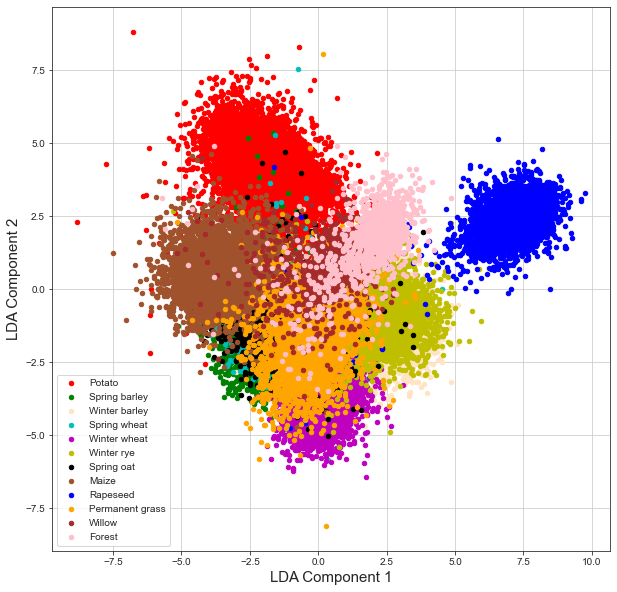

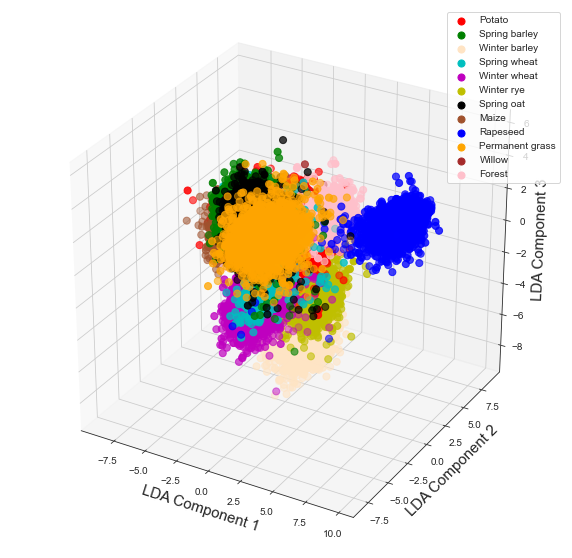

time: 4.15 s


In [35]:
LDA_plot_2D(X_lda_2D, df_sklearn_remapped, class_names)
LDA_plot_3D(X_lda_3D, df_sklearn_remapped, class_names)

# The 5 Crops We Study

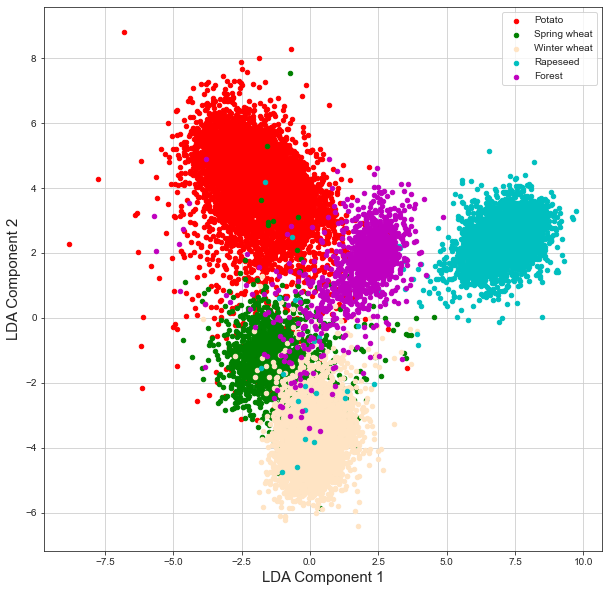

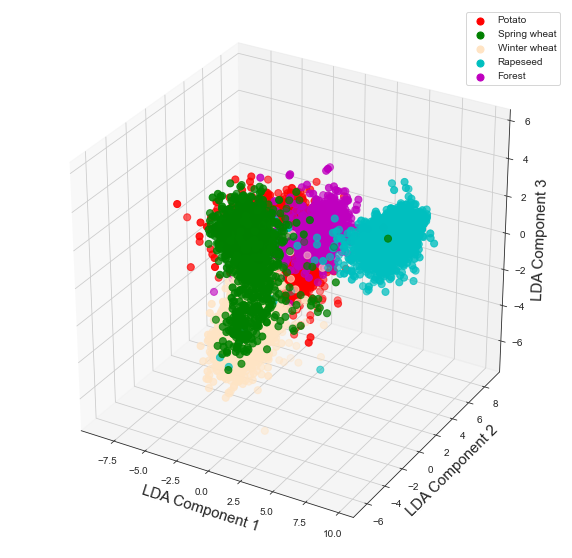

time: 1.86 s


In [53]:
LDA_plot_2D(X_lda_2D, df_sklearn_remapped, ['Potato', 'Spring wheat', 'Winter wheat', 'Rapeseed', 'Forest'])
LDA_plot_3D(X_lda_3D, df_sklearn_remapped, ['Potato', 'Spring wheat', 'Winter wheat', 'Rapeseed', 'Forest'])

# Top 5 (precision > 0.95 and recall > 0.95)

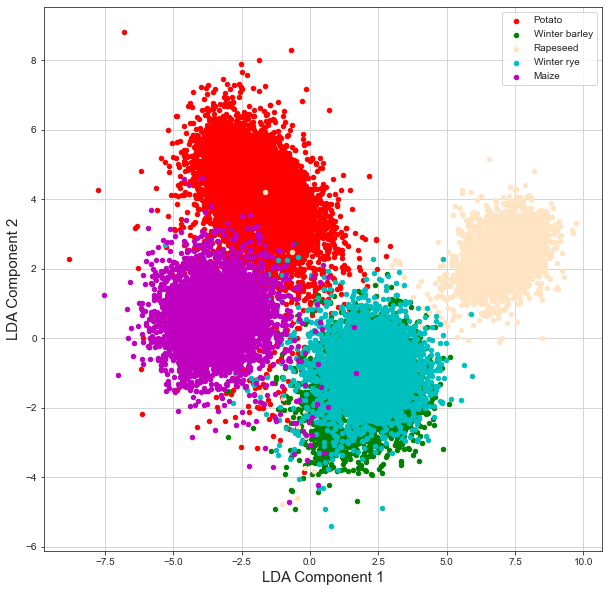

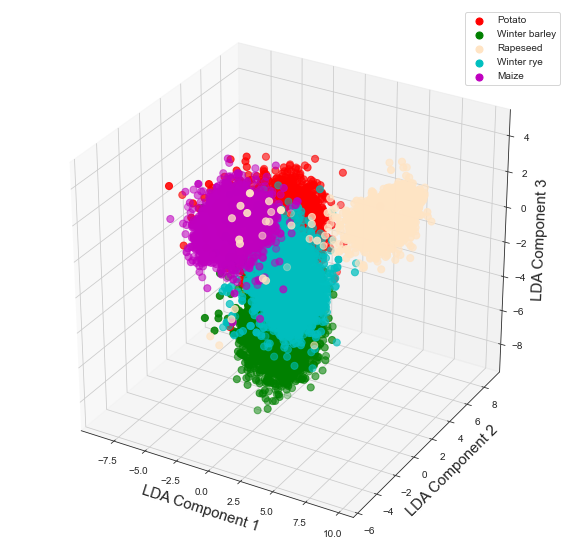

time: 2.26 s


In [37]:
LDA_plot_2D(X_lda_2D, df_sklearn_remapped, ['Potato', 'Winter barley', 'Rapeseed', 'Winter rye', 'Maize'])
LDA_plot_3D(X_lda_3D, df_sklearn_remapped, ['Potato', 'Winter barley', 'Rapeseed', 'Winter rye', 'Maize'])

# t-SNE - The below plots are for when data was for "all"

In [160]:
tsne, tsne_results = tsne_model(X, y, 2)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 44333 samples in 1.241s...
[t-SNE] Computed neighbors for 44333 samples in 1166.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44333
[t-SNE] Computed conditional probabilities for sample 2000 / 44333
[t-SNE] Computed conditional probabilities for sample 3000 / 44333
[t-SNE] Computed conditional probabilities for sample 4000 / 44333
[t-SNE] Computed conditional probabilities for sample 5000 / 44333
[t-SNE] Computed conditional probabilities for sample 6000 / 44333
[t-SNE] Computed conditional probabilities for sample 7000 / 44333
[t-SNE] Computed conditional probabilities for sample 8000 / 44333
[t-SNE] Computed conditional probabilities for sample 9000 / 44333
[t-SNE] Computed conditional probabilities for sample 10000 / 44333
[t-SNE] Computed conditional probabilities for sample 11000 / 44333
[t-SNE] Computed conditional probabilities for sample 12000 / 44333
[t-SNE] Computed conditional probabilities for

In [161]:
tsne_3D, tsne_results_3D = tsne_model(X, y, 3)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 44333 samples in 2.134s...
[t-SNE] Computed neighbors for 44333 samples in 1085.127s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44333
[t-SNE] Computed conditional probabilities for sample 2000 / 44333
[t-SNE] Computed conditional probabilities for sample 3000 / 44333
[t-SNE] Computed conditional probabilities for sample 4000 / 44333
[t-SNE] Computed conditional probabilities for sample 5000 / 44333
[t-SNE] Computed conditional probabilities for sample 6000 / 44333
[t-SNE] Computed conditional probabilities for sample 7000 / 44333
[t-SNE] Computed conditional probabilities for sample 8000 / 44333
[t-SNE] Computed conditional probabilities for sample 9000 / 44333
[t-SNE] Computed conditional probabilities for sample 10000 / 44333
[t-SNE] Computed conditional probabilities for sample 11000 / 44333
[t-SNE] Computed conditional probabilities for sample 12000 / 44333
[t-SNE] Computed conditional probabilities for

# All Crops

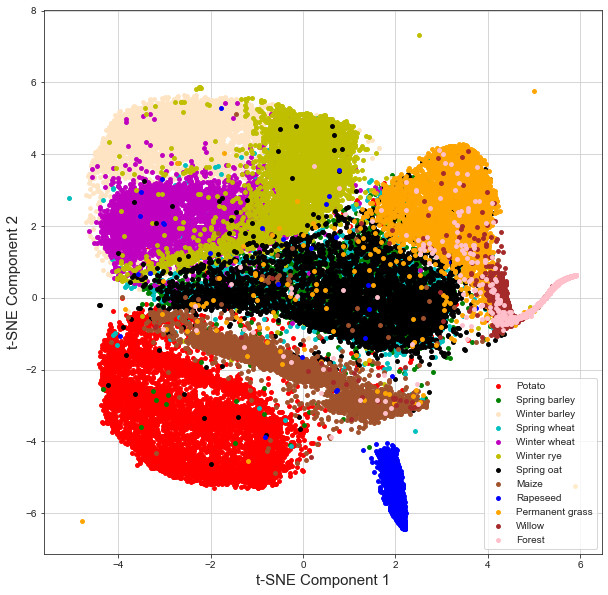

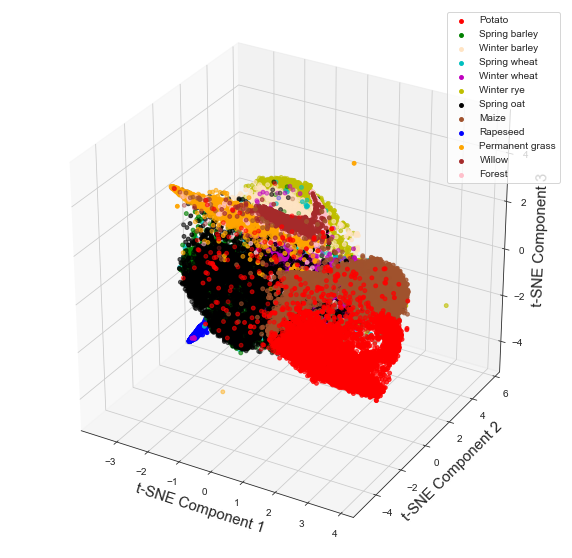

time: 3.81 s


In [166]:
tsne_plot_2D(tsne_results, df_sklearn_remapped, class_names)
tsne_plot_3D(tsne_results_3D, df_sklearn_remapped, class_names)

# 9 crops with good separation

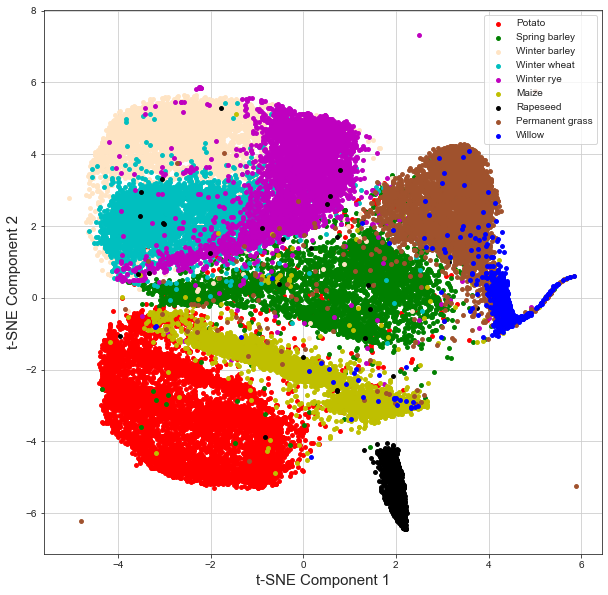

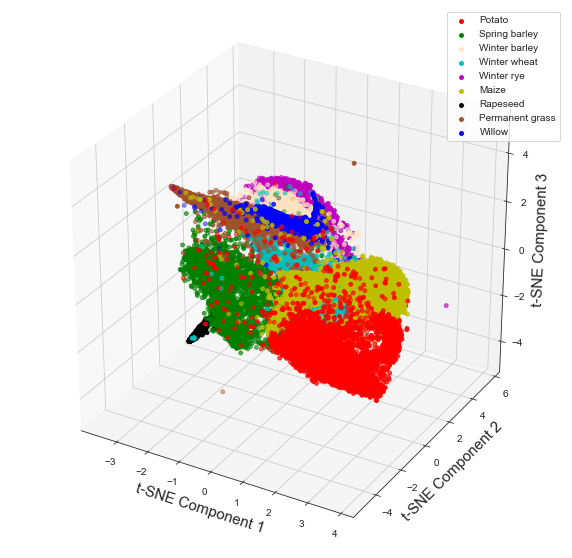

time: 3.51 s


In [170]:
tsne_plot_2D(tsne_results, df_sklearn_remapped, ['Potato', 'Spring barley', 'Winter barley', 'Winter wheat', 'Winter rye', 'Maize', 'Rapeseed', 'Permanent grass', 'Willow'])
tsne_plot_3D(tsne_results_3D, df_sklearn_remapped, ['Potato', 'Spring barley', 'Winter barley', 'Winter wheat', 'Winter rye', 'Maize', 'Rapeseed', 'Permanent grass', 'Willow'])

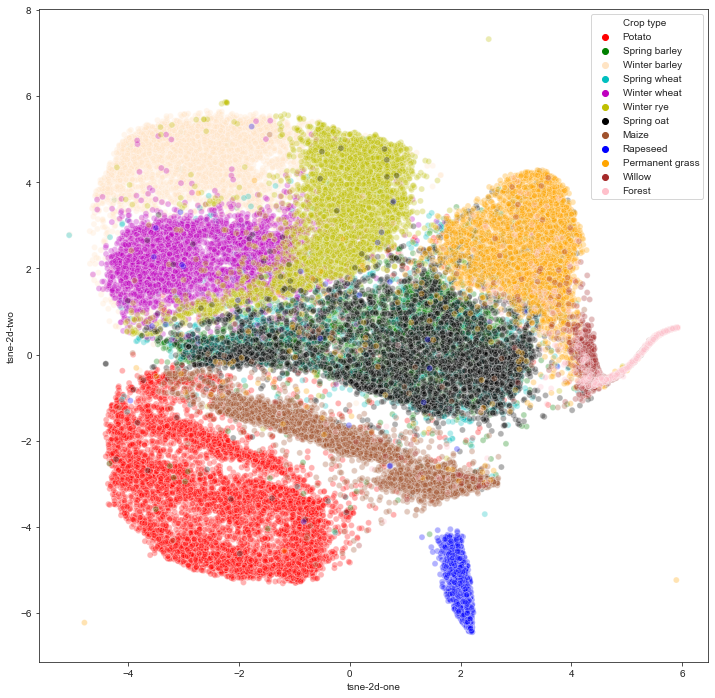

time: 3.16 s


In [172]:
seaborn_principalDf = pd.DataFrame(data = tsne_results
                 , columns = ['tsne-2d-one', 'tsne-2d-two'])
seaborn_finalDf = pd.concat([seaborn_principalDf, df_sklearn_remapped[['Crop type']]], axis = 1)
# seaborn_finalDf = finalDf.loc[finalDf['Crop type'].isin(crops)]
plt.figure(figsize=(12,12))
sns.scatterplot(
x='tsne-2d-one', y='tsne-2d-two',
hue="Crop type",
palette=['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink'],
#palette=['r', 'g', 'bisque','c'],
data=seaborn_finalDf,
legend="full",
alpha=0.3
)